# Gradients

Refs:
* Book: Elements of Statistical Learning
* https://www.deeplearningbook.org/  <== This is a goodreference for Deep Learning
* math demonstrations:
    * https://stats.stackexchange.com/questions/278771/how-is-the-cost-function-from-logistic-regression-derivated/278812 
    * https://medium.com/analytics-vidhya/derivative-of-log-loss-function-for-logistic-regression-9b832f025c2d
    * https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html
* Explanations and equations about momentum and others optmizers:
    * https://vzahorui.net/optimization/gradient-descent/
    
* Vidsual animations: https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c
* Learning Rate finder
    * https://miguel-data-sc.github.io/2017-11-05-first/
    * https://arxiv.org/pdf/1506.01186.pdf

This notebook reviews some central concepts in deep learning and implements the three main gradient descent algorithms using the NumPy library for linear regression and logistic regression. Latter, we introduce momentum and learning rate scheduler. While presenting the algorithms, we will be doing brief discussions about the impact of initialization, learning rate and outliers in the data.
  
--------
Terms used in deep learning:

* epoch: one pass over the entire data
* 1 step: update the parameters
* B: mini-batch size

ref: https://towardsdatascience.com/learning-parameters-part-3-ee8558f65dd7

| Gradient Algo                     | #steps in epoch |
|-----------------------------------|-----------------|
| Vanilla or Batch Gradient Descent | 1               |
| Stochastic Gradient Descent       | N               |
| Mini Batch Gradient Descent       | N/B             |



Analogy with Gravity:

* Potential Energy => Loss Function
* Goal Minimize Potential Energy => Minimize Loss Function 
* Mountain (x,y,z) => Regression Coefficient ($\theta$)
* modify (x,y) to archive the goal => modify $\theta$ to achive the goal
* Bottom of the Bowl or mountain => Minimum Value of Loss (Error)


In [1]:
import numpy as np
import random as rand

import matplotlib
import matplotlib.pyplot as plt
# required for iteractive plot
%matplotlib notebook  

import seaborn as sns

from sklearn.datasets import make_classification, make_regression
from sklearn.metrics import accuracy_score

from typing import List, Dict, Tuple, Callable

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

## Cost, Loss and hypothesis function


The terms **cost** and **loss** are many time used interchancheble by many authors (Ian Goodfellow, Yoshua Bengio, Aaron Courville ), other authors preffer to make a clear distinguish between them. Here we decide define this concepts and the concept of hypothesis in machine learning using the ref: https://stats.stackexchange.com/questions/179026/objective-function-cost-function-loss-function-are-they-the-same-thing .

* Hypothesis function $h_{\theta}(x, y)$
    1. It is the fucntional responsiple to do the mapping: (x -> y). It is the model you pick that you believe is the best to solve the task. 
    1. Ex in the context of Machine learning: linear regression, logistic regression and support vector machine all they have different $h_{\theta}(x, y)$. You neeed to determine the best by try and fail
    1. Ex context of deep learning: It is the different architecture you are tryng


* Loss function $\mathcal{L}(h_{\theta}(x^{(i)}), y_i)$
    1. It is the penality the algorithms pays by predicting $\hat{y}_i = h_{\theta}(x^{(i)}, y_i)$
        * if the estimation (prediction) is right $\hat{y}_i$, the penality should be zero
        * if the estimation (prediction) is wrong, the penality should increase with the difference between $\hat{y}_i$ and $y_i$
     1. It is a fucntion of data and not parameters. The parameters are assumed given and constant
     1. Examples of loss functions: Linear regression
     
$$
\mathcal{L}(x,y) =  \frac{1}{2} \left ( x \theta_1 + \theta_0 - y \right )^2 \\
h_{\theta_0,\theta_1}(x, y) = \left ( x \theta_1 + \theta_0 - y \right )^2
$$
     

* Cost function $J(\theta)$ 
    1. It is a function only of parameters. Data $x^{(i)},y_i$ are assumed as given and constant
    1. It is the average of the loss function over the dataset
    1. It means the average cost (penality) the algo paid for there mistakes over data sets or the complete batch
    
$$
J(\theta) = \frac{1}{n} \sum_{i=1}^n \mathcal{L}(h_{\theta}(x^{(i)}), y_i)
$$

## Gradient descent


In machine learning we define the loss fucntion $L = L(y, h_{\theta}(X))$. This function is reponsible  for penalizing mistakes. The machine learning algorithm learns by minimizing this function. $\theta$ are the paremeters of the models, $X$ is the trainning data, and $y$ are the labels. The term $h_{\theta}(X)$ is the hypothesis.  We define the cost function $J(\theta) = \frac{1}{n} \sum_{i=1}^n \mathcal{L}(h_{\theta}(x^{(i)}), y_i)$. Notices that the cost function $J(\theta)$ depends of the trainning data $X$, $y$ as well, but is considered only a function of the parameters $\theta$. Bellow is the cost function for Multiple Linear Regression:

$
J(\theta) =  \frac{1}{2n} \left ( X \theta - y \right )^t\left ( X \theta - y \right )
$

where $h_{\theta}(X) = X \theta$.

From calculus, 

$
d J(\theta) = \nabla_{\theta} J(\theta) * d\theta
$

where $*$ is the scalar product. Because the $cos(a)$ function is maximum when $a=0$ - $a$ is the angle between $\nabla_{\theta} J(\theta)$ and $d\theta$, therefore $\nabla_{\theta} J(\theta)$ and $d\theta$ are aligned - we know that the opposite direction of the gradient point to the direction that minimizes the cost function $J(\theta)$.

>PS: The opposite direction $\nabla_{\theta}J(\theta)$ minimizes the cost function. The gradient is a compass that instead of pointing North, is always pointing downhill.


The algorithm is summarized as follow:
    
1. Start from a random point $\theta = \theta_0$

1. Repeat the steps

    1. update direction (find the direction to minimize $J(\theta)$): $\Delta \theta = -\eta \nabla_{\theta}J(\theta)$
    
    1. update the position (keep changing the parameters to minimize $J(\theta)$): $\theta = \theta + \Delta \theta$
    
where $\eta$ is the **learning rate**. 

There are other gradienst variations. We will talk more about those variation in the next sections.


## Examples of cost functions and their gradients

**TODO**: review this. the notation mighr be inverted. X is th col vector and \theta is similar to W the parameter matrix 

The cost function can be defined in the matrix notation. The matrix notation simplifies the equations and makes it easy to implement the cost function and its gradients.

In this notation, in order to consider bias term (intercept) in both regression - logistic and linear - we must add a column of ones in the matrix $X$. The equations are the matrix representation of dataset of $n$ samples and $p$ features. 

$ 
X = \begin{bmatrix}
1 & a_1 & b_1 & c_1 & \ldots & p_1 \\
1 & a_2 & b_2 & c_2 & \ldots & p_2 \\
1 & a_2 & b_3 & c_3 & \ldots & p_3 \\
\vdots & \vdots & \ & \ldots &  & \vdots \\ 
1 & a_n & b_n & c_n & \ldots & p_n
\end{bmatrix}
$

where each row is an observation and $a$, $b$, $c$ ... $p$ are the features considered in the regression. The vector of parameters $\theta$, also called $W$ in deep learning, is a column vector of:

$ 
\theta = \begin{bmatrix}
\theta_0 \\
\theta_1 \\
\theta_2 \\
\vdots  \\ 
\theta_p
\end{bmatrix}
$

and the input of activation function can be expressed by $z = X\theta$. The equations of this section are assumed that $X$ and $\theta$ are in this form. Note that, the definition is different from the one implemented in TensorFlow, $z = WX + b$.


### Linear Regression: RMSE 

For linear regression problems we are going to present the **RMSE** cost function.


$
J(\theta) = \frac{1}{2n} \sum_i^n \left ( h_{\theta}(x_i) - y_i \right )^2
$

The equation above can be rewritten in a more concise way using the matrix notation.

$
J(\theta) = \frac{1}{2n} \left ( X \theta - y \right )^t\left ( X \theta - y \right )
$

And its gradient as:

$
\nabla_{\theta}J(\theta) = \frac{1}{n} X^t \left ( X\theta - y \right )
$


In [2]:
# X: matrix nxd
# y: column vector nx1
# theta: column vector dx1

def cost_func_linear_regression(theta: np.array, X: np.array, y: np.array) -> np.array:
    
    n = X.shape[0]
    
    # error: pred - y
    z = np.matmul(X,theta) - y

    return np.matmul(z.T,z)/2.0/n  # <== average of all loss MSE

def gradient_linear_regression(theta: np.array, X: np.array, y: np.array) -> np.array:
    
    n = X.shape[0]
    
    # error: pred - y
    z = np.matmul(X,theta) - y    
    grad = np.matmul(X.T,z)
        
    return grad/n

### Logistic Regression Sigmoid activation

* vectorized formula of the cost function: https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html

* Cost function is also called **Cross-entropy** or **log loss**


$
J(\theta) = \frac{1}{n} \sum_i^n \left ( y^i log(h_{\theta}(x_i)) - (1 - y_i) log(1 - h_{\theta}(x_i)) \right ) \\
J(\theta) = - \frac{1}{n} \left ( y^t log(h(X\theta)) + (1 - y)^t log(1 - h(X\theta))  \right )
$

$
\nabla_{\theta}J(\theta) = X^t \left ( \sigma(X\theta) - y) \right )
$

where:

$
h(X\theta) = h(z) = \sigma(z) \equiv \frac{1}{1 + e^{-z}} \\
\frac{\partial}{\partial z} \sigma(z) = \sigma(z) (1 - \sigma(z))  \\
z = X\theta
$


In [3]:
# X: matrix nxd
# y: column vector nx1
# theta: column vector dx1

def cost_func_logistic_regression(theta: np.array, X: np.array, y: np.array) -> np.array:
    
    n = X.shape[0]
    z = np.matmul(X,theta)  # nx1
    h = 1.0/(1.0 + np.exp(-z))  # activation: nx1
    
    cost = (-1.0/n)*(np.matmul(y.T,np.log(h)) + np.matmul(1-y.T,np.log(1-h))) # scalar
    
    return cost

def gradient_logistic_regression(theta: np.array, X: np.array, y: np.array)-> np.array:
    
    z = np.matmul(X,theta)
    
    # pred
    h = 1.0/(1.0 + np.exp(-z))  # activation
    
    return np.matmul(X.T,h - y)

## Simulated Data and auxiliar functions

In this section, simulated data is produced to test the gradients descent implementation.

True parameters: [4. 5.]
bayes error: 0.01


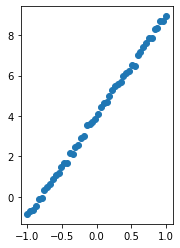

In [4]:
def make_2d_linear_data(slope: float, intercept: float, noise: float, 
                        n_samples: int, random: int = 2021):
    
    x = np.linspace(-1.0, 1.0, n_samples).reshape(n_samples,1)
    
    np.random.seed(random)
    e = np.random.normal(0.0,noise,n).reshape(n_samples,1)
    
    y = slope*x + intercept + e
    y = y.reshape(n,)

    _ones = np.ones((n_samples,1))

    x.shape

    _ones.shape

    X = np.hstack((_ones, x))
    
    return X,y, e

slope = 5.0 
intercept = 4.0
noise = 0.1
n = 50

X,y, e = make_2d_linear_data(slope,intercept, noise, n)
theta_true = np.array([intercept,slope])

print(f"True parameters: {theta_true}")

bayes_error = np.sum(np.matmul(e.T,e))/n  # <== mse
print(f"bayes error: {bayes_error:.2f}")

_ = plt.subplot(121);
_ = plt.scatter(X[:,1],y);

plt.show()

In [6]:
def generate_parameter_space(grid_size: int,theta_range: tuple, 
                         cost_func: Callable[[np.array,np.array], np.array],
                            X: np.array, y: np.array):
    
    theta_start, theta_end = theta_range
    
    theta1 = np.linspace(theta_start, theta_end, grid_size)
    theta2 = np.linspace(theta_start, theta_end, grid_size)

    Theta1,Theta2 = np.meshgrid(theta1,theta2)

    J_grid = np.zeros((grid_size,grid_size))
    theta = np.array([0.0,0.0]).T
    for r in range(0,grid_size):
    
        for c in range(0,grid_size):
        
            theta[0] = theta1[r]
            theta[1] = theta2[c]
        
            J_grid[r,c] = cost_func(theta, X,y)
            
      
    return Theta1, Theta2, J_grid
            

def plot_parameter_space_experiment(Theta1, Theta2, J_grid, theta_true: tuple, 
                                    history: dict,
                                    experiment: List[Tuple]):
    
    intercept, slope = theta_true
    
    cp = plt.contour(Theta1, Theta2, J_grid)
    colors = ['b','k','firebrick']

    for idx, hyper_params in enumerate(experiment):
        name = hyper_params[0]
       
        #name, bs, lr,init_guess = hyper_params
    
        theta_x = [ history[name]['theta'][k][0] for k in range(0, len(history[name]['theta']),1) ]
        theta_y = [ history[name]['theta'][k][1] for k in range(0, len(history[name]['theta']),1) ]
    
        plt.plot(theta_x, theta_y, color=colors[idx], marker='.', markersize=1, label=name)

    plt.title('Contour Plot')
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    plt.scatter(intercept,slope)  # <= Expected true value
    plt.grid(axis='x', color='0.95')
    plt.grid(axis='y', color='0.95')
    plt.legend()
    plt.show();
    

## Batch Gradient descent


Batch gradient descent computes the gradient using the whole dataset. 

In [7]:
def gradient_descent(X: np.array,y: np.array, 
                     cost_func: Callable[[np.array,np.array], np.array], 
                     gradient_func: Callable[[np.array,np.array], np.array], 
                     learning_rate: float, 
                     n_iterations: int, init_guess: np.array) -> dict:
    
    n = X.shape[0] # training size
    d = X.shape[1]  # number of dimensions or paramters
    
    theta_history = np.zeros((n_iterations,d))
    grad_history = np.zeros((n_iterations,d))
    cost_history = np.zeros(n_iterations)
    

    theta = init_guess

    for it in range(0,n_iterations):

        # compute gradients and cost function
        cost_at_theta = cost_func(theta,X,y)
        gradient_at_theta = gradient_func(theta,X,y)

        # log history for ploting
        theta_history[it, :] = theta.T
        grad_history[it,:] = gradient_at_theta.T
        cost_history[it] = cost_at_theta
        
        # update parameters
        dtheta = -learning_rate* gradient_at_theta
        theta = theta + dtheta

    history = {'theta': theta_history, "cost": cost_history, "grad": grad_history}

    return theta, history

### Training 

True parameters: 32.69


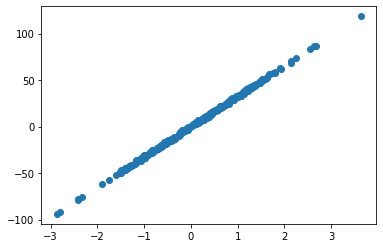

In [8]:
X, y, theta_true = make_regression(n_samples = 300, 
                       n_features=1, 
                       n_informative=1, 
                       noise=1,  # <== This is related with the bayes error. The minimum the cost function can converted
                        coef=True,
                       random_state=2021)

print(f"True parameters: {theta_true:.2f}")

plt.scatter(X,y);

In [9]:
%%time
lr = 0.05
n_iter = 100

init_guess = np.array([50.0])

theta, history = gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                  lr, n_iter, init_guess)

print()
theta0 = history['theta'][0]
grad0 =  history['grad'][0]
cost0 = history['cost'][0]

print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

it = n_iter -1
theta = history['theta'][it]
grad =  history['grad'][it]
cost = history['cost'][it]

print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
print(f"Expected theta:{theta_true:.2f}")


Initial Guess it: 0 => theta: [50.]; grad: [17.66328858]; cost: 153.96
it: 99 => theta: [32.7167683]; grad: [0.10120038]; cost: 0.45
Expected theta:32.69
CPU times: user 5.13 ms, sys: 1.38 ms, total: 6.5 ms
Wall time: 5.37 ms


### Checking the fit

We can inspect our solution by ploting the prediction against the data.

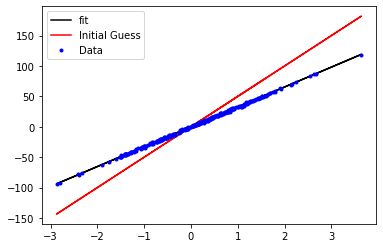

In [10]:
y_pred0 = np.matmul(X,theta0)
y_pred = np.matmul(X,theta)

plt.plot(X,y_pred,c='black', label='fit');
plt.plot(X,y_pred0,'r', label='Initial Guess');
plt.plot(X,y,'b.', label='Data');
plt.legend();

### Cost Function and  learning rate 

Learning rates are central points in the algorithm. Good values of learning rate can make gradient descent find a local minimum quick on the other hand, bad values can lead to problems.

1. large: 
    * cost function increases or,
    * cost function decrease rapidly in the beginning but stabilized in the high plateau
1. small: takes longer for learning
1. need to find the optimum learning rate

<img src="images/understanding_learning_rate.png" style="float:left" width="800" align="right">

CPU times: user 38.6 ms, sys: 3.43 ms, total: 42 ms
Wall time: 41.7 ms


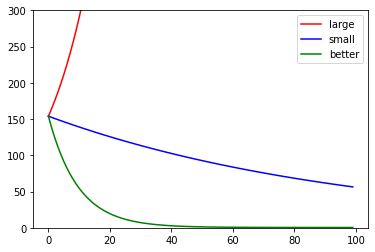

In [11]:
%%time
n_iter
lr = 2.0

experiment = [('large', 2.0),
             ('small', 5e-3),
             ('better', 0.05)
             ]

history = {}
for name, lr in experiment:

    _, history[name] = gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                          lr, n_iter, init_guess)


fig,ax = plt.subplots()
colours = ['r', 'b', 'g']

for idx, hyperparmeter in enumerate(experiment):

    name, lr = hyperparmeter
    _ = ax.plot(range(n_iter),history[name]['cost'],colours[idx],label=name);

_ = ax.set_ylim([0, 300.0])
ax.legend();

The learning rate can be tune using the methodology describe in the section **8. TUNNING Learning Rate**

### Changing bayes error

The error can be decomposed on bias, variance and Bayes error. The Bayes error can NOT be reduced. Therefore the cost function should converge to this value.

$y = \hat{y} + \epsilon$

* $\epsilon$ is the bayes error 
* $\epsilon \sim N(h_{\theta}(x),\sigma^2)$  <== Our simulated data and, statistics have this assumption for Multiple Linear regression models.


True parameters: 32.69


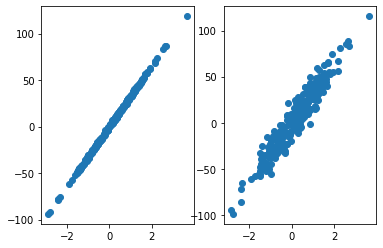

In [12]:
n_sample = 300
std_low_bayes_error = 1

X_low_bayes_error, y_low_bayes_error, theta_true = make_regression(n_samples = n_sample, 
                       n_features=1, 
                       n_informative=1, 
                       noise=std_low_bayes_error,  # <== Low bayes error
                        coef=True,
                       random_state=2021)

print(f"True parameters: {theta_true:.2f}")


std_high_bayes_error = 10
X_high_bayes_error, y_high_bayes_error, theta_true = make_regression(n_samples = n_sample, 
                       n_features=1, 
                       n_informative=1, 
                       noise=std_high_bayes_error,  # <== High bayes error
                        coef=True,
                       random_state=2021)

_ = plt.subplot(121);
_ = plt.scatter(X_low_bayes_error,y_low_bayes_error);
_ = plt.subplot(122);
_ = plt.scatter(X_high_bayes_error,y_high_bayes_error);

plt.show()

In [13]:
%%time
lr = 0.05
n_iter = 100

init_guess = np.array([50.0])

theta, history_low_bayes_error = gradient_descent(X_low_bayes_error, y_low_bayes_error, cost_func_linear_regression, gradient_linear_regression, 
                                  lr, n_iter, init_guess)


theta, history_high_bayes_error = gradient_descent(X_high_bayes_error, y_high_bayes_error, cost_func_linear_regression, gradient_linear_regression, 
                                  lr, n_iter, init_guess)


CPU times: user 7.28 ms, sys: 2.09 ms, total: 9.37 ms
Wall time: 7.82 ms


In [14]:
J_low_bayes_error = 1.0/2.0*pow(std_low_bayes_error,2) # <= half of std^2
print(f"Low bayes Error: Cost function converged to {history_low_bayes_error['cost'][-1]} vs expected {std_low_bayes_error**2/2.0}")

J_high_bayes_error = 1.0/2.0*pow(std_high_bayes_error,2) # <= half of std^2
print(f"High bayes Error: Cost function converged to {history_high_bayes_error['cost'][-1]} vs expected {std_high_bayes_error**2/2.0}")

Low bayes Error: Cost function converged to 0.4498957115700963 vs expected 0.5
High bayes Error: Cost function converged to 44.491052934509085 vs expected 50.0


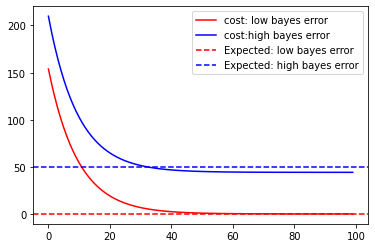

In [15]:
fig,ax = plt.subplots()
_ = ax.plot(range(n_iter),history_low_bayes_error['cost'],'r',label='cost: low bayes error');
_ = ax.plot(range(n_iter),history_high_bayes_error['cost'],'b',label='cost:high bayes error');
_ = ax.axhline(y=J_low_bayes_error, color='r', linestyle='--',label='Expected: low bayes error');
_ = ax.axhline(y=J_high_bayes_error, color='b', linestyle='--',label='Expected: high bayes error');
ax.legend();

### Testing Logistic Regression

We are going to verify our solution using **logistic regression and cross-entropy cost function**

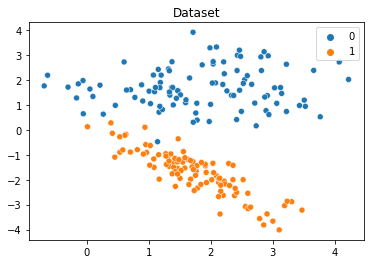

In [16]:
# other options are also available
X, y = make_classification(
    n_samples=200, 
    n_classes=2,
    n_clusters_per_class=1,
    n_features=2,
    n_redundant = 0,
    n_informative = 2,
    n_repeated = 0,
    weights=[0.5,0.5], # balanced classes
    flip_y=0.001, # add noisy the default value for flip_y is 0.1%
    class_sep=1.7, # class_sep is 1.0. The lower the value, the harder classification is.
    random_state=2021) 

ax = sns.scatterplot(X[:,0],X[:,1],hue=y);
ax.set_title("Dataset");

In [17]:
%%time
lr = 0.02
n_iter = 25

init_guess = np.array([0.0,-1.5])

theta, history = gradient_descent(X, y, cost_func_logistic_regression, gradient_logistic_regression, 
                                  lr, n_iter, init_guess)

print()
theta0 = history['theta'][0]
grad0 =  history['grad'][0]
cost0 = history['cost'][0]

print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

it = n_iter -1
theta = history['theta'][it]
grad =  history['grad'][it]
cost = history['cost'][it]

print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")


Initial Guess it: 0 => theta: [ 0.  -1.5]; grad: [ 7.52433034 22.29189721]; cost: 0.14
it: 24 => theta: [-0.30564022 -3.74217532]; grad: [0.1072965  1.56981277]; cost: 0.05
CPU times: user 4.76 ms, sys: 2.76 ms, total: 7.52 ms
Wall time: 5.22 ms


**Checking fit: Measuring the perfromance on train dataset**

In [18]:
z = np.matmul(X,theta)  # nx1
h = 1.0/(1.0 + np.exp(-z)) 
y_pred = h > 0.5

acc = accuracy_score(y, y_pred)
print(f"accuracy: {acc}")

accuracy: 0.98


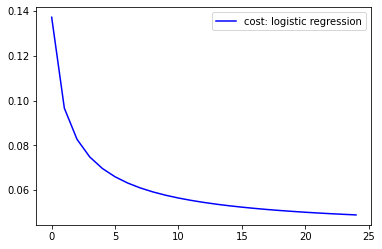

In [19]:
fig,ax = plt.subplots()
_ = ax.plot(range(n_iter),history['cost'],'b',label='cost: logistic regression');
ax.legend();

### Case: 2D feature space 

Checking with 2d paremeters space.

In [20]:
slope = 5.0 
intercept = 4.0
noise = 0.1
n = 50

X,y,_ = make_2d_linear_data(slope,intercept, noise, n)
theta_true = np.array([intercept,slope])

In [21]:
%%time
lr =0.1
n_iter = 200

init_guess = np.array([-10.0, -10.0])

theta, history = gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                             lr, n_iter, init_guess)

print()
theta0 = history['theta'][0]
grad0 =  history['grad'][0]
cost0 = history['cost'][0]

print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

it = n_iter -1
theta = history['theta'][it]
grad =  history['grad'][it]
cost = history['cost'][it]

print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
print(f"Expected theta:{theta_true}")


Initial Guess it: 0 => theta: [-10. -10.]; grad: [-14.01099638  -5.19944385]; cost: 137.12
it: 199 => theta: [4.01099637 4.97332617]; grad: [-1.09831868e-08 -4.61640576e-03]; cost: 0.00
Expected theta:[4. 5.]
CPU times: user 6.84 ms, sys: 3.26 ms, total: 10.1 ms
Wall time: 7.93 ms


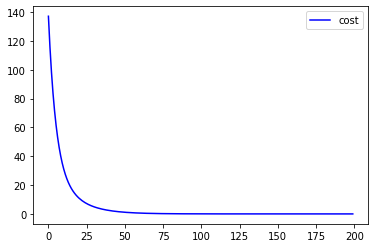

In [22]:
fig,ax = plt.subplots()
_ = ax.plot(range(n_iter),history['cost'],'b',label='cost');
ax.legend();

Generating parameters space

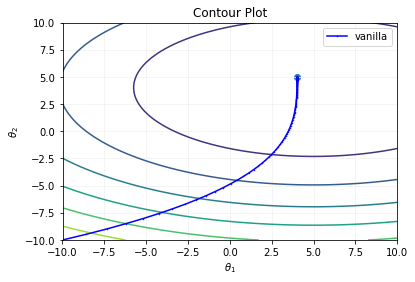

In [23]:
Theta1, Theta2, J_grid = generate_parameter_space(grid_size=500,theta_range=(-10.0,10.0),
                                                  cost_func=cost_func_linear_regression,
                                                 X=X,y=y)

grad_exp = [('vanilla', lr)]
history2 = { 'vanilla': history}

plot_parameter_space_experiment(Theta1, Theta2, J_grid,theta_true=(intercept,slope),
                                history=history2,
                                experiment=grad_exp)

## Stochastic Gradient Descent

In stochastic Gradient descent, instead of using the entire data $X$ to compute the gradients, we randomly peak one sample and use it to estimate the gradients at that point. The estimation will not be accurate, but the algorithm will converge to an optimal solution on average. The algorithm is illustrated below:

The update formula is given by:

$
\theta = \theta - \eta \nabla_{\theta}J(X_i)
$

* Start with initial guess: $\theta$

* for each iteration

    1. random shuffle $X$
    1. for i=0,1,..., n-1
        1. Compute  $\nabla_{\theta}J(X_i)$
        1. update the parameters $\theta = \theta - \eta \nabla_{\theta}J(X_i)$


In [24]:
def stochastic_gradient_descent(X: np.array,y: np.array, 
                     cost_func: Callable[[np.array,np.array], np.array], 
                     gradient_func: Callable[[np.array,np.array], np.array], 
                     learning_rate: float, 
                     n_iterations: int, init_guess: np.array) -> dict:
    
    n = X.shape[0]  # training size
    d = X.shape[1]  # number of dimensions or paramters
    
    Xy = np.hstack((X,y.reshape((n,1))))
    
    theta_history = []
    grad_history = []
    cost_history = []
     
    theta = init_guess
    for it in range(1,n_iterations):

        cost = 0.0
        
        # shuffle data
        rand_idx = np.random.randint(0, n, n )
        data_shuffle = Xy[rand_idx,:]
        
        for i in range(n):

            X_i = data_shuffle[i,:-1].reshape(1, d)
            y_i = data_shuffle[i,-1]
            
            cost += cost_func(theta,X_i,y_i)
            gradient_at_theta = gradient_func(theta,X_i,y_i)  # gradient approximation using 1 data point
            
            # log history for oploting
            theta_history.append(theta.T)
            grad_history.append(gradient_at_theta)
            
           # update parameters
            dtheta = -learning_rate* gradient_at_theta

            theta = theta + dtheta
                
        cost_history.append(cost/n)   # <= average loss in the epoch 
        
    history = {'theta': theta_history, "cost": cost_history, "grad": grad_history}

    return theta, history

#### Case: 1D parameter sapce

True parameters: 26.52


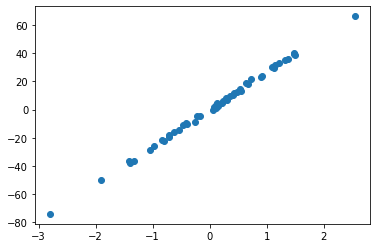

In [25]:
# Simulating data
X, y, theta_true = make_regression(n_samples = 50, 
                       n_features=1, 
                       n_informative=1, 
                       noise=1.0,
                       coef=True,
                       random_state=2021)

print(f"True parameters: {theta_true:.2f}")
plt.scatter(X,y);

In [26]:
%%time
lr =0.001
n_iter = 120

init_guess = np.array([20])

theta, history = stochastic_gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                             lr, n_iter, init_guess)

print()
theta0 = history['theta'][0]
grad0 =  history['grad'][0]
cost0 = history['cost'][0]

print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

it = n_iter -1
theta = history['theta'][-1]
grad =  history['grad'][-1]
cost = history['cost'][-1]

print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
print(f"Expected theta:{theta_true:.2f}")


Initial Guess it: 0 => theta: [20]; grad: [-0.18600079]; cost: 16.57
it: 119 => theta: [26.50866704]; grad: [0.80460918]; cost: 0.54
Expected theta:26.52
CPU times: user 165 ms, sys: 7.46 ms, total: 172 ms
Wall time: 210 ms


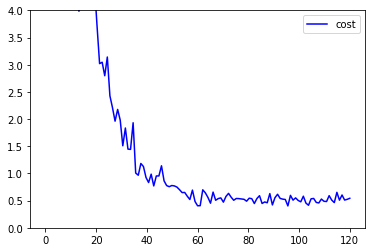

In [27]:
fig,ax = plt.subplots()

cost = history['cost']
    
m = len(cost)
x = np.linspace(0,n_iter,m)

_ = ax.plot(x,cost,'b',label='cost');
_ = ax.set_ylim([0, 4.0])
ax.legend();

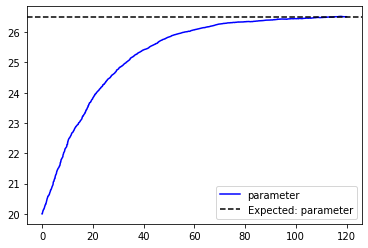

In [28]:
fig,ax = plt.subplots()

parameters = history['theta']
    
m = len(parameters)
x = np.linspace(0,n_iter,m)
    
_ = ax.plot(x,parameters,'b',label='parameter');
_ = ax.axhline(y=theta_true, color='k', linestyle='--',label='Expected: parameter');
ax.legend();

#### Case: 2D parameters space

In [29]:
slope = 5.0 
intercept = 4.0
noise = 0.5
n = 50

X,y,_ = make_2d_linear_data(slope,intercept, noise, n)
theta_true = np.array([intercept,slope])

In [30]:
%%time
lr = 0.01
n_iter = 30

init_guess = np.array([-10.0, -10.0])

theta, history = stochastic_gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                             lr, n_iter, init_guess)

print()
theta0 = history['theta'][0]
grad0 =  history['grad'][0]
cost0 = history['cost'][0]

print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

it = n_iter -1
theta = history['theta'][-1]
grad =  history['grad'][-1]
cost = history['cost'][-1]

print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
print(f"Expected theta:{theta_true}")


Initial Guess it: 0 => theta: [-10. -10.]; grad: [-0.43347429  0.3803958 ]; cost: 109.68
it: 29 => theta: [4.05686163 4.88635486]; grad: [-0.57379776  0.57379776]; cost: 0.12
Expected theta:[4. 5.]
CPU times: user 48.6 ms, sys: 3.4 ms, total: 52 ms
Wall time: 52.9 ms


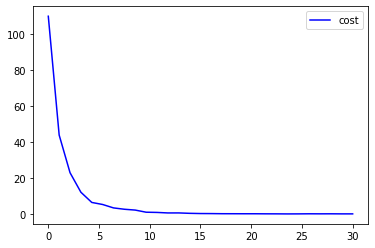

In [31]:
fig,ax = plt.subplots()

cost = history['cost']
    
m = len(cost)
x = np.linspace(0,n_iter,m)
    
_ = ax.plot(x,cost,'b',label='cost');
ax.legend();

Generating parameters space

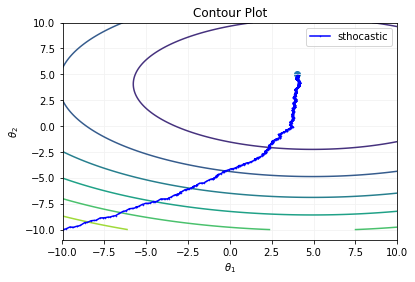

In [32]:
Theta1, Theta2, J_grid = generate_parameter_space(grid_size=500,theta_range=(-10.0,10.0),
                                                  cost_func=cost_func_linear_regression,
                                                 X=X, y=y)

grad_exp = [('sthocastic', 1)]
history2 = { 'sthocastic': history}

plot_parameter_space_experiment(Theta1, Theta2, J_grid,theta_true=(intercept,slope),
                                history=history2,
                                experiment=grad_exp)

## Mini Batch Gradient Descent

In the case of mini-batch, instead of making an update considering only one data point at a time, we calculate gradients using a batch of data points of size B. Mini batch can be seen as a generalization of the previous algorithm:

1. Batch gradient descent, $𝐵=|X|$ where $|X|$ denotes (cardinality) the training dataset size
1. Online stochastic gradient descent: $𝐵=1$ (updates are doing using the last random gradient estimation)
1. Mini-batch stochastic gradient descent: $𝐵>1$ but $𝐵<|𝑥|$.

> Note: Actually, we're reading these training example data from memory and, due to cache pre-fetching and other memory tricks done by the computer, the algorithm runs faster if the memory accesses are coalesced, i.e. when you read the memory in order and don't jump around randomly. So, most SGD implementations shuffle the dataset and then load the examples into memory in the order that they'll be read.

> Note: Online stochastic gradient descent is not the same as Sthocastibc gradient descent. The first uses the most recent gradients to update the parameters while the latter pic up a random point. 

> Note: proper weight should be assigned to each mini-batch as a function of its size when there are mini-batches with different size because the number of training examples are not exactly divided by the batch size.

The points below summarize the advantages and disadvantages of each algorithm.

* Gradient descent: 
    * Gradients are precise. 
    * Computationally slow
    * Resource hungry: Load the entire training dataset in memory 
    * Numerical convergence slow because 1 update per epoch
    
* Stochastic:
    * Gradients are NOT precise. The cost function has oscillations.
    * Do not consume too much resource 
    * Lack of parallelism
    * Faster numerical convergence. $n$ updates per epoch where $n$ is the training dataset
 
 * Mini batch
     * Gradients are more precise than Stochastic. The cost function oscillates less than Stochastic gradient descent. 
     * Computationally fast because can explore parallelism 
     * Fast numerical convergence because there are many updates per epoch
     * Do not use too many resources

In the next cell follows the implementation.

In [33]:
def create_mini_batches(data_shuffle, batch_size):
    
    n = data_shuffle.shape[0]
    mini_batches = []
    
    for k in np.arange(0, n, batch_size):
        
        X_mini = data_shuffle[k:k+batch_size,:-1]
        y_mini = data_shuffle[k:k+batch_size,-1]
        
        mini_batches.append((X_mini,y_mini))
    return mini_batches

def mini_batch_gradient_descent(X: np.array,y: np.array, 
                     cost_func: Callable[[np.array,np.array], np.array], 
                     gradient_func: Callable[[np.array,np.array], np.array], 
                     learning_rate: float, 
                     n_iterations: int, 
                     batch_size: int,
                     init_guess: np.array) -> dict:
    
    n = X.shape[0] # training size
    d = X.shape[1]  # number of dimensions or paramters
    
    theta = init_guess

    Xy = np.hstack((X,y.reshape((n,1))))
        
    theta_history = []
    grad_history = []
    cost_history = []
 
    for it in range(1,n_iterations):
        
        data_shuffle = Xy.copy()
        np.random.shuffle(data_shuffle)
        
        cost = 0.0
        mini_batches = create_mini_batches(data_shuffle,batch_size)
        
        for X_mini, y_mini in mini_batches:

            # compute the gradients and cost function
            cost += cost_func(theta,X_mini,y_mini)
            gradient_at_theta = gradient_func(theta,X_mini,y_mini)  # gradient approximation
        
            # log history for oploting
            theta_history.append(theta.T)
            grad_history.append(gradient_at_theta)
            
           # update parameters
            dtheta = -learning_rate* gradient_at_theta

            theta = theta + dtheta
            
        cost_history.append(cost/len(mini_batches)) # << average loss in the epoch 

    history = {'theta': theta_history, "cost": cost_history, "grad": grad_history}

    return theta, history

### Case: 2D feature space compare all approaches (Linear Regression)

To test our implementation, we are going to run in-batches for different batch sizes and compare the learning curves and the travel performed by each run. All runs start close to each other but not the same initial parameter's guesses.

In [34]:
slope = 5.0 
intercept = 4.0
noise = 0.1
n = 50

X,y,_ = make_2d_linear_data(slope,intercept, noise, n)
theta_true = np.array([intercept,slope])

In [35]:
%%time
n_iter = 150

print(f"#samples: {n}")

init_guess = np.array([-10.0, -10.0])
d1 = np.array

history = dict()

experiment = [('sthocastic',1, 0.02,  np.array([-10.0, -10.0]) ),
               ('mini',12, 0.02,  np.array([-9.0, -10.0])), 
               ('vanila',n, 0.02, np.array([-10.0, -9.0]) )]

for name, bs, lr, init_guess in experiment:

    theta, history[name] = mini_batch_gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                             lr, n_iter,bs, init_guess)

    print(f"{name}, bs: {bs}")
    theta0 = history[name]['theta'][0]
    grad0 =  history[name]['grad'][0]
    cost0 = history[name]['cost'][0]

    print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

    it = n_iter -1
    theta = history[name]['theta'][-1]
    grad =  history[name]['grad'][-1]
    cost = history[name]['cost'][-1]

    print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
    print(f"Expected theta:{theta_true}")
    print()

#samples: 50
sthocastic, bs: 1
Initial Guess it: 0 => theta: [-10. -10.]; grad: [-16.09563875  -2.29937696]; cost: 71.11
it: 149 => theta: [4.00485465 4.9856539 ]; grad: [-0.02859749 -0.01108882]; cost: 0.00
Expected theta:[4. 5.]

mini, bs: 12
Initial Guess it: 0 => theta: [ -9. -10.]; grad: [-10.63049228  -3.36001783]; cost: 130.95
it: 149 => theta: [4.00719305 4.89946225]; grad: [-0.0648019  -0.00561593]; cost: 0.01
Expected theta:[4. 5.]

vanila, bs: 50
Initial Guess it: 0 => theta: [-10.  -9.]; grad: [-14.01099638  -4.85250508]; cost: 132.09
it: 149 => theta: [ 3.30641977 -0.00410597]; grad: [-0.70457661 -1.73148062]; cost: 4.57
Expected theta:[4. 5.]

CPU times: user 237 ms, sys: 10.5 ms, total: 247 ms
Wall time: 296 ms


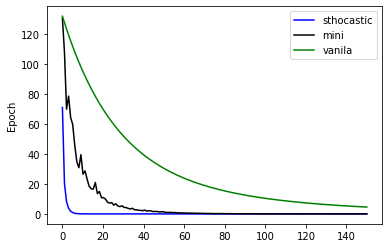

In [36]:
colors = ['b','k','g']

fig,ax = plt.subplots()
for idx, hyper_params in enumerate(experiment):
    
    name, bs, lr,_ = hyper_params
    
    cost = history[name]['cost']
    
    m = len(cost)
    x = np.linspace(0,n_iter,m)
    
    _ = ax.plot(x,cost,colors[idx],label=name);

_ = ax.set_ylabel("Cost")
_ = ax.set_ylabel("Epoch")
ax.legend();

As you can see from the graph above, the fastest algorithm is Stochastic, followed by mini-batch as expected.

* **Confirming fit**

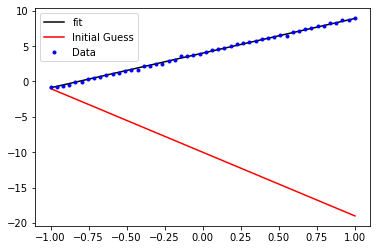

In [37]:
name = 'mini'

theta = history[name]['theta'][-1]
y_pred0 = np.matmul(X,init_guess)
y_pred = np.matmul(X,theta)

y_pred.shape

plt.plot(X[:,1],y_pred,c='black', label='fit');
plt.plot(X[:,1],y_pred0,'r', label='Initial Guess');
plt.plot(X[:,1],y,'b.', label='Data');
plt.legend();

Comparing the runs, see graph below. It can be noticed that vanilla gradients descent travel directly to the local minimum while stochastic gradient travel by oscillating around the mini-batch gradient descent travel that can be seen as a smoothed version of the stochastic gradient descent.

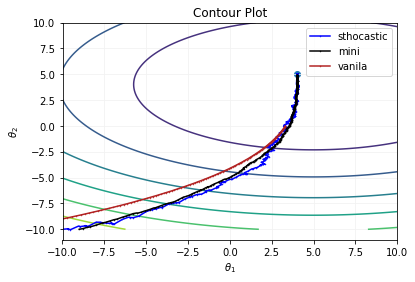

In [38]:
Theta1, Theta2, J_grid = generate_parameter_space(grid_size=500,theta_range=(-10.0,10.0),
                                                  cost_func=cost_func_linear_regression,
                                                 X=X, y=y)

plot_parameter_space_experiment(Theta1, Theta2, J_grid,theta_true=(intercept,slope),
                                history=history,
                                experiment=experiment)

## TUNING Learning rate 

**TODO:** Review this section

One of the most critical hyperparameters and hard to tune in a deep neural network is the learning rate $\eta$. The author of https://arxiv.org/abs/1506.01186 introduced this methodology to help determine the acceptable range of learning rates. 

The learning rate hyperparameter is not constant anymore, but a function of the iteration and the update equation can be written as:

$
\theta_t = \theta_{t-1} + \eta(t) \nabla J(\theta)
$

The function $\eta(t)$ is called the learning rate scheduler function. The methodology is described below.

1. start very small learning rate
1. increase exponentially
1. record learning rate vs cost function

The acceptable learning rate is illustrated in the figure.

<img src="images/learing_rate_finder_lr_plot.png" style="float:left" width="500" align="right">

The figure below (extract from https://miguel-data-sc.github.io/2017-11-05-first/) shows that big batches allow big learning rates and allow the gradients to learn faster. Intuitively, a large batch size computes more precise gradients, which allows taking large steps since the gradients are pointing in the right direction (descent direction).

<img src="images/learning_rate_vs_batch_sizes.png" style="float:left" width="600" align="right">

In [39]:
from abc import ABC, abstractmethod

class LearningRateScheduler(ABC):

    def __init__(self, lr0: float ):
        
        self._lr0 = lr0
        
    @abstractmethod
    def run(it: int) -> float: 
        return
    
class ConstLearningRateScheduler(LearningRateScheduler):
    
    def run(self, it: int) -> float: 
        return self._lr0
    
class FindLearningRateScheduler(LearningRateScheduler):
    
    def __init__(self, lr0: float, number_of_lr_per_order: int = 4 ):
    
        super().__init__(lr0)
        
        self._lr0 = lr0
        self._number_of_lr_per_order = number_of_lr_per_order
    
    def run(self, it: int) -> float: 
        
        lr = self._lr0*(10**(it/self._number_of_lr_per_order))
        
        return lr

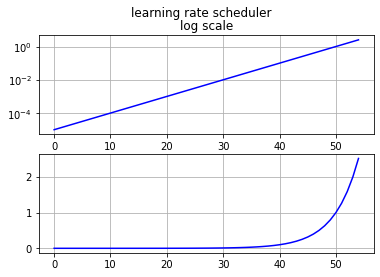

In [40]:
n_iter = 55

lr_scheduler = FindLearningRateScheduler(1e-5,number_of_lr_per_order=10)

lrs = np.zeros((n_iter,))
for it in range(n_iter):
    
    lrs[it] = lr_scheduler.run(it)

fig, (ax1, ax2) = plt.subplots(2);
fig.suptitle('learning rate scheduler');
ax1.plot(range(n_iter),lrs,'b',label='');
ax1.set_yscale('log');
ax1.grid(True);
ax1.set_title('log scale');
ax2.plot(range(n_iter),lrs,'b',label='learning rate scheduler');
ax2.grid(True);

In [41]:
def create_mini_batches(data_shuffle, batch_size):
    
    n = data_shuffle.shape[0]
    mini_batches = []
    
    for k in np.arange(0, n, batch_size):
        
        X_mini = data_shuffle[k:k+batch_size,:-1]
        y_mini = data_shuffle[k:k+batch_size,-1]
        
        mini_batches.append((X_mini,y_mini))
    return mini_batches

def mini_batch_gradient_descent(X,y, cost_func, gradient_func, 
                                learning_rate_scheduler: Callable[[float,int], float],
                                n_iterations: int,
                                batch_size: int, 
                                init_guess: np.array,seed: int =1):
    
    n = X.shape[0] # training size
    d = X.shape[1]  # number of dimensions or paramters
    
    theta = init_guess

    Xy = np.hstack((X,y.reshape((n,1))))
        
    theta_history = []
    grad_history = []
    cost_history = []
 
    np.random.seed(seed)
    for it in range(0,n_iterations):
           
        data_shuffle = Xy.copy()
        np.random.shuffle(data_shuffle)
        
        cost = 0.0
        mini_batches = create_mini_batches(data_shuffle,batch_size)
        
        for X_mini, y_mini in mini_batches:

            # compute the gradients and cost function
            cost += cost_func(theta,X_mini,y_mini)
            gradient_at_theta = gradient_func(theta,X_mini,y_mini)  # gradient approximation using 1 data point
            

            # log history for oploting
            theta_history.append(theta.T)
            grad_history.append(gradient_at_theta)
            
           # update parameters
            learning_rate = learning_rate_scheduler.run(it)
            dtheta = -learning_rate* gradient_at_theta

            theta = theta + dtheta
            
        cost_history.append(cost/len(mini_batches)) # << average loss in the epoch 

    history = {'theta': theta_history, "cost": cost_history, "grad": grad_history}

    return theta, history

In [42]:
slope = 5.0 
intercept = 4.0
noise = 0.1
n = 100

X,y,_ = make_2d_linear_data(slope,intercept, noise, n)
theta_true = np.array([intercept,slope])

In [43]:
n_iter = 53
bs = 18

lr_scheduler = FindLearningRateScheduler(1e-6,number_of_lr_per_order=8)

init_guess = np.array([1.0,0.5])


theta, history = mini_batch_gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                             lr_scheduler, n_iter,bs, init_guess)



theta0 = history['theta'][0]
grad0 =  history['grad'][0]
cost0 = history['cost'][0]

print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

it = n_iter -1
theta = history['theta'][-1]
grad =  history['grad'][-1]
cost = history['cost'][-1]

print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")

print()

Initial Guess it: 0 => theta: [1.  0.5]; grad: [-3.72681679 -1.60126421]; cost: 7.81
it: 52 => theta: [-47.90706221  14.36635469]; grad: [-50.92189002  -0.4599745 ]; cost: 280.19



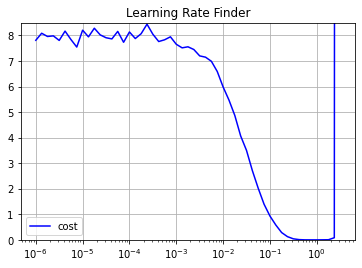

In [44]:
lrs = np.zeros((n_iter,))
for it in range(n_iter):
    
    lrs[it] = lr_scheduler.run(it)

cost = history['cost'] 

plt.subplots()
plt.plot(lrs,cost,'b',label='cost');
plt.xscale('log');
plt.ylim(0.0,8.5);
plt.legend();
plt.title('Learning Rate Finder');
plt.grid(True);

In [47]:
experiment = [('too low',1e-3),
              ('start learning',0.01),
              ('good', 0.1),
              ('start become high', 1.0 ),
             ('too high',2.0)]

n_iter = 25
print(f"batch size: {bs}")

for name, lr in experiment:

    init_guess = np.array([1.0,2.5])
    
    lr_scheduler = ConstLearningRateScheduler(lr)
    
    theta, history[name] = mini_batch_gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                             lr_scheduler, n_iter,bs, init_guess)


    print(f"{name}, lr: {lr}")
    theta0 = history[name]['theta'][0]
    grad0 =  history[name]['grad'][0]
    cost0 = history[name]['cost'][0]

    print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

    it = n_iter -1
    theta = history[name]['theta'][-1]
    grad =  history[name]['grad'][-1]
    cost = history[name]['cost'][-1]

    print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
    print()

batch size: 18
too low, lr: 0.001
Initial Guess it: 0 => theta: [1.  2.5]; grad: [-3.39909513 -1.10977241]; cost: 5.46
it: 24 => theta: [1.41769124 2.62411064]; grad: [-2.20392831 -0.51109307]; cost: 4.30

start learning, lr: 0.01
Initial Guess it: 0 => theta: [1.  2.5]; grad: [-3.39909513 -1.10977241]; cost: 5.26
it: 24 => theta: [3.34262054 3.49620248]; grad: [-0.44637018 -0.51355311]; cost: 0.63

good, lr: 0.1
Initial Guess it: 0 => theta: [1.  2.5]; grad: [-3.39909513 -1.10977241]; cost: 3.73
it: 24 => theta: [4.00879345 4.99008009]; grad: [-0.06690105 -0.01279004]; cost: 0.01

start become high, lr: 1.0
Initial Guess it: 0 => theta: [1.  2.5]; grad: [-3.39909513 -1.10977241]; cost: 1.19
it: 24 => theta: [3.9866028 4.999784 ]; grad: [-0.09095407 -0.00444789]; cost: 0.01

too high, lr: 2.0
Initial Guess it: 0 => theta: [1.  2.5]; grad: [-3.39909513 -1.10977241]; cost: 7.33
it: 24 => theta: [4.81420755 4.9914372 ]; grad: [ 0.7382526 -0.1667934]; cost: 0.32



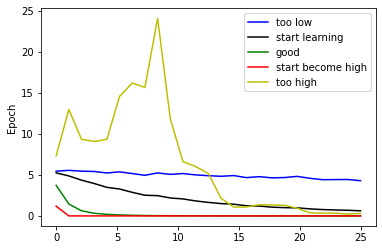

In [48]:
colors = ['b','k','g', 'r','y']

fig,ax = plt.subplots()
for idx, hyper_params in enumerate(experiment):
    
    name, lr = hyper_params= hyper_params
    
    cost = history[name]['cost']
    
    m = len(cost)
    x = np.linspace(0,n_iter,m)
    
    _ = ax.plot(x,cost,colors[idx],label=name);

_ = ax.set_ylabel("Cost")
_ = ax.set_ylabel("Epoch")
ax.legend();

## Impact of outlier: Gradient Exploding

In this section, we are going to show that in the presence of outliers, gradient descent can become numerical unstable and the gradients can increase and explode to numerical precision of the computer. The stochastic gradients descent is the most sensible to outliers because the computation of the gradient depends only on one sample.


True parameters: [4. 5.]


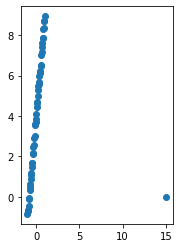

In [49]:
slope = 5.0 
intercept = 4.0
noise = 0.1
n = 50

X,y,_ = make_2d_linear_data(slope,intercept, noise, n)
theta_true = np.array([intercept,slope])

outlier_X = [1., 15] 
outlier_y = 0.0

X1 = np.vstack((X,outlier_X))
y1 = np.hstack((y,outlier_y))

print(f"True parameters: {theta_true}")

_ = plt.subplot(121);
_ = plt.scatter(X1[:,1],y1);

plt.show()

In [50]:
lr = 0.01
n_iter = 30
bs = 51
init_guess = np.array([-10.0, -10.0])

experiment = [('No outlier: sthochastic',1,(X,y)),
             ('Outlier: sthochastic',1, (X1,y1)),
             ('Outlier: mini',8, (X1,y1)),
             ('Outlier: vanila',51, (X1,y1))
              ]

lr_scheduler = ConstLearningRateScheduler(lr)

history = {}
for name, bs, data in experiment:
    
    X_sim,y_sim = data
    
    theta, history[name] = mini_batch_gradient_descent(X_sim, y_sim, cost_func_linear_regression, gradient_linear_regression, 
                                             lr_scheduler, n_iter,bs, init_guess)
    print()
    theta0 = history[name]['theta'][0]
    grad0 =  history[name]['grad'][0]
    cost0 = history[name]['cost'][0]

    print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

    it = n_iter -1
    theta = history[name]['theta'][-1]
    grad =  history[name]['grad'][-1]
    cost = history[name]['cost'][-1]

    print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
    print(f"Expected theta:{theta_true}")


Initial Guess it: 0 => theta: [-10. -10.]; grad: [-15.66823832  -1.59879983]; cost: 96.46
it: 29 => theta: [4.01322287 4.91002963]; grad: [0.24300042 0.13389819]; cost: 0.01
Expected theta:[4. 5.]

Initial Guess it: 0 => theta: [-10. -10.]; grad: [-12.60111687   1.28582825]; cost: 291.22
it: 29 => theta: [  1.14275622 -46.24840334]; grad: [-54.04233093 -54.04233093]; cost: 4321.54
Expected theta:[4. 5.]

Initial Guess it: 0 => theta: [-10. -10.]; grad: [ -34.90401357 -307.43969367]; cost: 347.90
it: 29 => theta: [2.23215894 0.22637753]; grad: [-1.93365105 -2.3330057 ]; cost: 6.00
Expected theta:[4. 5.]

Initial Guess it: 0 => theta: [-10. -10.]; grad: [-16.87352587 -52.1563175 ]; cost: 385.41
it: 29 => theta: [-6.11355424 -1.81423465]; grad: [-10.57950206 -12.11530065]; cost: 69.01
Expected theta:[4. 5.]


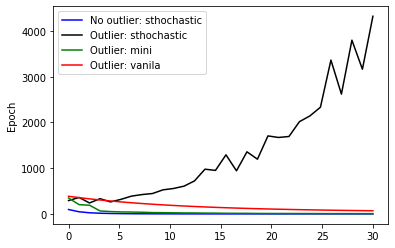

In [51]:
colors = ['b','k','g','r']

fig,ax = plt.subplots()
for idx, sim_param in enumerate(experiment):
    
    name, bs, data = sim_param
    
    cost = history[name]['cost']
    
    m = len(cost)
    x = np.linspace(0,n_iter,m)
    
    _ = ax.plot(x,cost,colors[idx],label=name);

_ = ax.set_ylabel("Cost")
_ = ax.set_ylabel("Epoch")
ax.legend();


## Gradient descent with Momentum 

Intuitively momentum adds a term that can be understood as an inertial term (velocity) in the update equation. This inertia also makes the gradient descent with momentum oscillates more when it is near the local minimum of the cost function.  Other solutions try to address this phenomena: **AdaGrad**, **RMSProp** and **Adam (momentum+ RMSProp) (This is the best available right now)**. However, these solutions are not discussed in this **notebook**.

The momentum was inspired by the concept of **exponential moving average** (exponential smoothing).

$
V_t = \beta V_{t-1} + (1-\beta)S_t
$

where $S_t$ is a new observation and $\beta = [0,1]$. The new smooth value is a linear combination of the new observation $S_t$ and the old smoothed value $V_{t-1}$ and $\beta$ determine the fraction of the old smoothed value will be "remember". In the analogy of the physical system, $V$ denotes velocity and the term $\beta V_{t-1}$ is the resistance applied in the previous velocity and $(1 -\beta)S_t$ is the acceleration at the current time. 

This equation reduces the gradient oscillations because a considered amount of the gradient oscillation is cancelled due to the resistance term. The equation for the gradient is given by: 

$
V_t = \beta V_{t-1} + (1-\beta) \eta \nabla J(\theta)
$

Since the learning rate can be selected to account for the term $(1- \beta)$, thus making it redundant, this term is usually omitted in the literature or in the implementation of the algorithm. 

$
V_t = \beta V_{t-1} + \eta \nabla J(\theta)
$

Where $\eta = (1-\beta) \eta $. The parameters are updated with the formula:

$
\theta_t = \theta_{t-1} + V_t
$

Default value $\beta = 0.9$  works well in many situations.

* $\beta = 0$: normal gradients (no momentum)
* $\beta = 1$: pure momentum and the gradients are ignored in the update, and the algorithm does not converge.

Below, we added momentum to the gradient descent implementation. Besides, we are going to show that momentum makes gradient descent converge faster.

In [52]:
def gradient_descent(X: np.array,y: np.array, 
                     cost_func: Callable[[np.array,np.array], np.array], 
                     gradient_func: Callable[[np.array,np.array], np.array], 
                     learning_rate: float, beta: float,
                     n_iterations: int, init_guess: np.array) -> dict:
    
    n = X.shape[0] # training size
    d = X.shape[1]  # number of dimensions or paramters
    
    theta_history = np.zeros((n_iterations,d))
    grad_history = np.zeros((n_iterations,d))
    cost_history = np.zeros(n_iterations)

    theta = init_guess

    V = 0.0
    for it in range(0,n_iterations):

        # compute gradients and cost function
        cost_at_theta = cost_func(theta,X,y)
        gradient_at_theta = gradient_func(theta,X,y)

        # log history for ploting
        theta_history[it, :] = theta.T
        grad_history[it,:] = gradient_at_theta.T
        cost_history[it] = cost_at_theta
        
        # update parameters
        V = beta*V - learning_rate*gradient_at_theta
        theta = theta + V

    history = {'theta': theta_history, "cost": cost_history, "grad": grad_history}

    return theta, history

In [54]:
slope = 5.0 
intercept = 4.0
noise = 0.1
n = 50

X,y,_ = make_2d_linear_data(slope,intercept, noise, n)
theta_true = np.array([intercept,slope])

In [55]:
lr = 0.05
n_iter = 75

experiment = [('vanilla', 0.00),
       ('momentum good',0.70 ),
       ('momentum large',0.95 )]

init_guess = np.array([5.0,-1.0])  ## <== also works well

init_guess = np.array([-10.0, -10.0])

for name, beta in experiment:

    theta, history[name] = gradient_descent(X, y,
                                            cost_func_linear_regression, gradient_linear_regression,
                                            lr, beta, 
                                            n_iter, init_guess)

    print(f"{name}, beta: {beta}")
    theta0 = history[name]['theta'][0]
    grad0 =  history[name]['grad'][0]
    cost0 = history[name]['cost'][0]

    print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

    it = n_iter -1
    theta = history[name]['theta'][-1]
    grad =  history[name]['grad'][-1]
    cost = history[name]['cost'][-1]

    print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
    
    print()

vanilla, beta: 0.0
Initial Guess it: 0 => theta: [-10. -10.]; grad: [-14.01099638  -5.19944385]; cost: 137.12
it: 74 => theta: [3.69621009 0.8815705 ]; grad: [-0.31478629 -1.42420511]; cost: 2.98

momentum good, beta: 0.7
Initial Guess it: 0 => theta: [-10. -10.]; grad: [-14.01099638  -5.19944385]; cost: 137.12
it: 74 => theta: [4.01097547 4.89739794]; grad: [-2.09171352e-05 -3.09588523e-02]; cost: 0.01

momentum large, beta: 0.95
Initial Guess it: 0 => theta: [-10. -10.]; grad: [-14.01099638  -5.19944385]; cost: 137.12
it: 74 => theta: [5.18075583 7.22837338]; grad: [1.16975945 0.77774691]; cost: 1.56



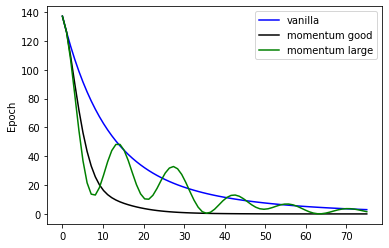

In [56]:
colors = ['b','k','g']

fig,ax = plt.subplots()
for idx, hyper_params in enumerate(experiment):
    
    name, beta = hyper_params= hyper_params
    
    cost = history[name]['cost']
    
    m = len(cost)
    x = np.linspace(0,n_iter,m)
    
    _ = ax.plot(x,cost,colors[idx],label=name);
    
_ = ax.set_ylabel("Cost")
_ = ax.set_ylabel("Epoch")
ax.legend();

As you can see, gradient with momentum converges fast than regular vanilla gradient descent.

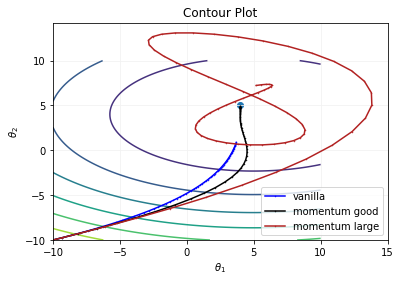

In [57]:
Theta1, Theta2, J_grid = generate_parameter_space(grid_size=300,theta_range=(-10.0,10.0),
                                                  cost_func=cost_func_linear_regression,
                                                 X=X,y=y)

plot_parameter_space_experiment(Theta1, Theta2, J_grid,theta_true=(4.0,5.0),
                                history=history,
                                experiment=experiment)

The graphs above show that the parameter $\beta = 0.95$ (momentum large) makes the cost function oscillate around the local minimum as mentioned before (This is the problem that **Adam** optimization addresses). On the other hand, choosing properly $\beta$ makes the gradient converge faster than the vanilla gradient. 

## Impact of initialization in Neural Network: 

In this section we are going to use tensorflow to demonstrate the impact of the initialization on gradients. 

1. Constant initialization poor perform
1. zero: not learning 
1. too-large: leads too gradients vanish and not learning
1. constant:  hard to learn (poor performance)

Recently, the best to initialzation methods, see https://www.deeplearning.ai/ai-notes/initialization/, are:

* Xavier: better for sigmoid activations
* He: better for Relu types activations

We are not discussing this methods in this notebook.  We are going to build a simple neural network with 2 layers and 2 neurons.


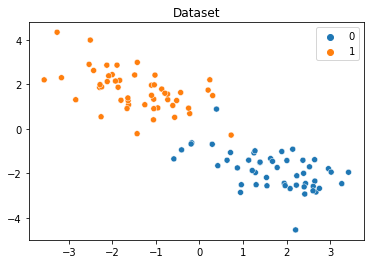

In [58]:
# other options are also available
X, y = make_classification(
    n_samples=100, 
    n_classes=2,
    n_clusters_per_class=1,
    n_features=2,
    n_redundant = 0,
    n_informative = 2,
    n_repeated = 0,
    weights=[0.5,0.5], # balanced classes
    flip_y=0.001, # add noisy the default value for flip_y is 0.1%
    class_sep=1.7, # class_sep is 1.0. The lower the value, the harder classification is.
    random_state=2020) 

ax = sns.scatterplot(X[:,0],X[:,1],hue=y);
ax.set_title("Dataset");

Remember that the input of the activations function on TensorFlow is given by $z = WX + b$

In [59]:
init_guess
n_iter = 50
lr = 0.05

# manual
W00 = tf.constant_initializer(1.0)
b00 = tf.constant_initializer(0.5)
W01 = tf.constant_initializer(-1.0)
b01 = tf.constant_initializer(0.0)

# constant
WB_const = tf.constant_initializer(0.5)

# grad vanish regions
WB_grad_vanish = tf.constant_initializer(5.0)

# Zero
WB0 = tf.constant_initializer(0.0)

# random: uniform
np.random.seed(2021)
W00_rd = tf.constant_initializer(np.random.uniform(-1.0,1.0,1))
b00_rd = tf.constant_initializer(np.random.uniform(-1.0,1.0,1))
W01_rd = tf.constant_initializer(np.random.uniform(-1.0,1.0,1))
b01_rd = tf.constant_initializer(np.random.uniform(-1.0,1.0,1))


experiment = [('manual',X.shape[0], (W00,b00,W01,b01)),
               ('const',X.shape[0], (WB_const,WB_const,WB_const,WB_const)),
               ('grad vanish',X.shape[0], (WB_grad_vanish,WB_grad_vanish,WB_grad_vanish,WB_grad_vanish)),
               ('zero',X.shape[0], (WB0,WB0,WB0,WB0)),
               ('random',X.shape[0], (W00_rd,b00_rd,W01_rd,b01_rd)),
              ]

models = {}
for name, bs, initialization in experiment:

    
    W00,b00,W01,b01 = initialization

    print(f"{name}:")
    print(f" ==> Layer 0: {W00((1,1)).numpy()},{b00((1,1)).numpy()}")
    print(f" ==> Layer 1: {W01((1,1)).numpy()},{b01((1,1)).numpy()}")
    
    
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
    models[name] = tf.keras.Sequential([
                tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=W00,
                          bias_initializer=b00,
                          input_shape=(2,)),
                tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=W01,
                          bias_initializer=b01,
                          input_shape=(1,))
    ])


    sgd = tf.keras.optimizers.SGD(learning_rate=lr, 
                              momentum=0.0,
                              nesterov=False, name='SGD'
                             )

    models[name].compile(loss='mse', optimizer=sgd, metrics=['mse'])

    

    _ = models[name].fit(X, y, epochs=n_iter, batch_size=bs, verbose=0, validation_split=0.0)
    
    
print("Last model summary and config")
models[name].summary()
models[name].optimizer.get_config()



array([-10., -10.])

manual:
 ==> Layer 0: [[1.]],[[0.5]]
 ==> Layer 1: [[-1.]],[[0.]]
const:
 ==> Layer 0: [[0.5]],[[0.5]]
 ==> Layer 1: [[0.5]],[[0.5]]
grad vanish:
 ==> Layer 0: [[5.]],[[5.]]
 ==> Layer 1: [[5.]],[[5.]]
zero:
 ==> Layer 0: [[0.]],[[0.]]
 ==> Layer 1: [[0.]],[[0.]]
random:
 ==> Layer 0: [[0.21195656]],[[0.46673872]]
 ==> Layer 1: [[-0.72210569]],[[-0.37465383]]
Last model summary and config
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1)                 3         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


{'name': 'SGD',
 'learning_rate': 0.05,
 'decay': 0.0,
 'momentum': 0.0,
 'nesterov': False}

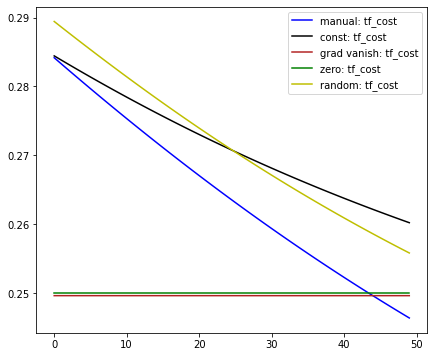

In [60]:
colors = ['b','k','firebrick','g', 'y', 'v', 'o']


fig,ax = plt.subplots(figsize=(7,6))
for idx, sim  in enumerate(experiment): 

    name, bs, initialization = sim 
    tf_cost = models[name].history.history['loss']
    
    # re scaling cost for better visualization purpose
    if name == 'grad vanish':
        tf_cost = [value/2.0 for value in tf_cost]
    
    _ = ax.plot(range(n_iter),tf_cost,colors[idx],label=f'{name}: tf_cost');

ax.legend();

As you can see in the graph above, by initializing the neural network with all parameters to zero or high parameters values, the neural network is NOT capable of learning.

Besides, if the neural networks are initialized with constant values, this results in poor performance.